In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from wordcloud import WordCloud

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("data.csv")
df.head()

,gender,industry,job_title,majors
0,male,telecommunications,project manager,NaN
1,male,events services,biscuit,NaN
2,NaN,design,psycotherapist bibliotherapist,NaN
3,male,computer software,performance\\\\\\\\system tl,engineering
4,NaN,marketing and advertising,executive irector,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   gender     78952 non-null   object
 1   industry   101136 non-null  object
 2   job_title  108987 non-null  object
 3   majors     68800 non-null   object
dtypes: object(4)
memory usage: 3.7+ MB


In [4]:
def plot_word_cloud_for(df, colname):
    text =""
    for description in df[colname]:
        if isinstance(description, str):
            text += " " + description
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

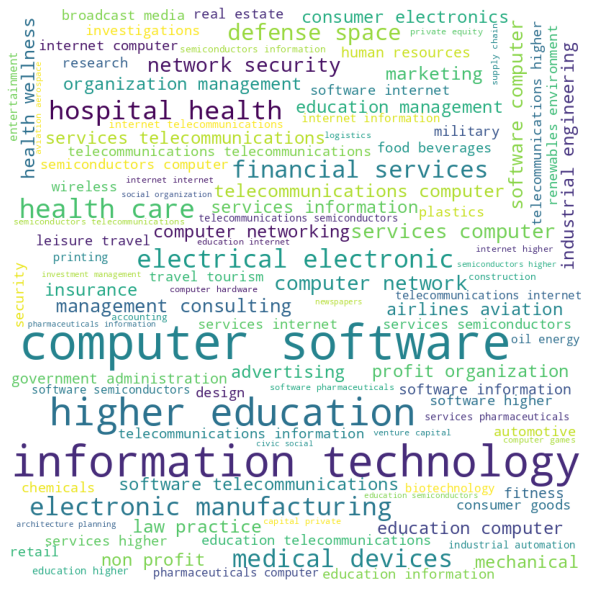

In [5]:
plot_word_cloud_for(df, "industry")

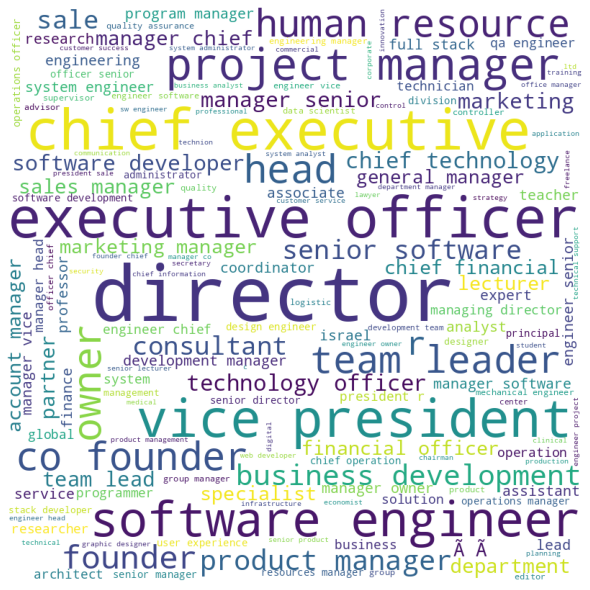

In [6]:
plot_word_cloud_for(df, "job_title")

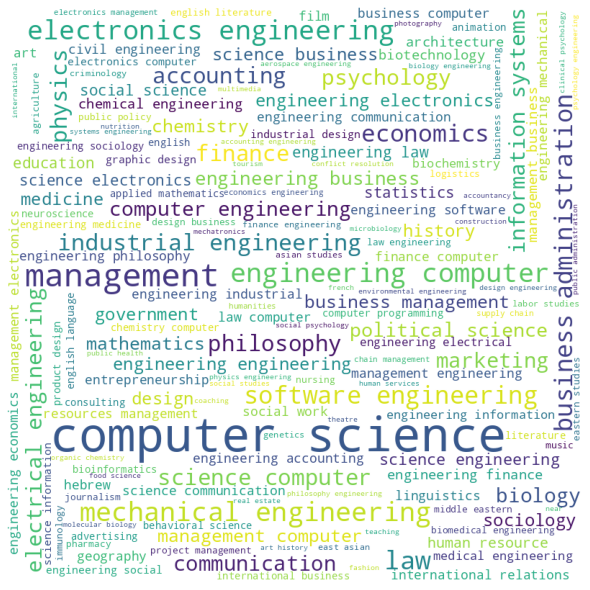

In [7]:
plot_word_cloud_for(df, "majors")

In [8]:
# 10 most popular majors
list(zip(
    df['majors'].value_counts().tolist()[:10]
    ,df['majors'].value_counts().index.tolist()[:10]
))


[(7523, 'computer science'),
 (3742, 'management'),
 (3627, 'engineering'),
 (2457, 'law'),
 (2277, 'business'),
 (1949, 'finance'),
 (1767, 'economics'),
 (1743, 'electronics'),
 (1653, 'mechanical engineering'),
 (1602, 'accounting')]

<AxesSubplot:xlabel='gender', ylabel='count'>

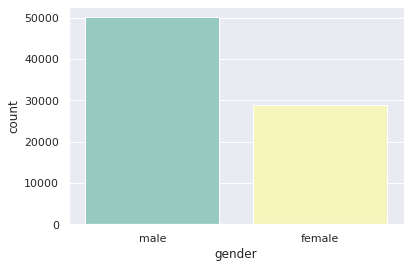

In [9]:
# Understand how genders distributed
sns.countplot(x="gender", data=df, order=["male", "female"],palette="Set3")

Gender and software in job titles


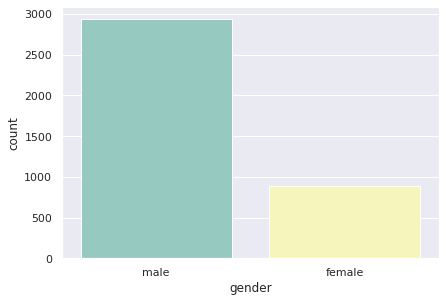

In [10]:
def plot_gender_with_keyword(df, keyword):
    sdf = df.dropna(subset=['gender','job_title'])
    sdf = sdf.loc[sdf["job_title"].str.contains(keyword)]
    sns.countplot(data=sdf, x="gender",order=["male", "female"],palette="Set3")
    plt.tight_layout(pad = 0)
    plt.show()
print("Gender and software in job titles")
plot_gender_with_keyword(df,"software")

Gender and electronic in job titles


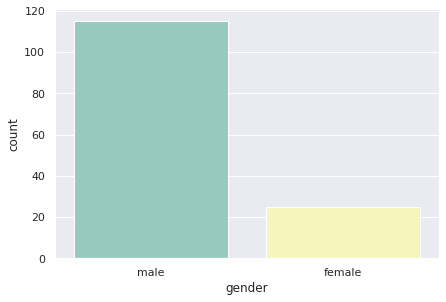

In [11]:
print("Gender and electronic in job titles")
plot_gender_with_keyword(df,"electronic")

Gender and human resource in job titles


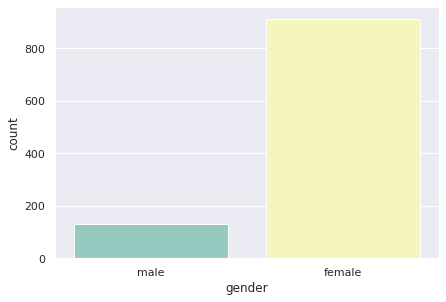

In [12]:
print("Gender and human resource in job titles")
plot_gender_with_keyword(df,"human resource")

# Clustering 
Combining the columns industry, job_title and majors. tring to find cluster using K-means

In [13]:
def to_string(obj):
    if(isinstance(obj, str)):
        return obj
    else: # obj is not str (NaN) returning empty string
        return ""

df['text'] = df['industry'].map(to_string)\
     + " " + df['job_title'].map(to_string)\
     + " " + df['majors'].map(to_string)

preprocessing the text

In [14]:
word_Lemmatized = WordNetLemmatizer()

def preprocess(text):
    global word_Lemmatized 
    lower = text.lower()
    # Tokenization
    tokens = word_tokenize(lower)
    # Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
    # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV 
    Final_words = ""
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(tokens):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words += " " + word_Final
    return Final_words

df['cleaned'] = df['text'].map(preprocess)


TF-IDF

In [15]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned'])

Perform k-means clustering

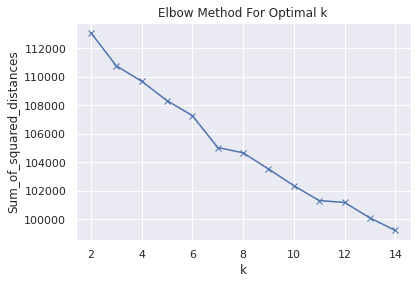

In [16]:
Sum_of_squared_distances = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=1, max_iter=300)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [17]:
true_k = 7
model = KMeans(n_clusters=true_k, random_state=1, max_iter=300)
model.fit(X)

KMeans(n_clusters=7, random_state=1)

In [18]:
df["cluster"] = model.labels_

Cluster: 0


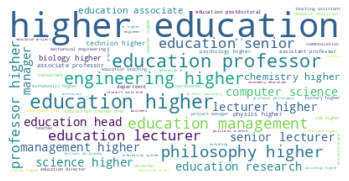

Cluster: 1


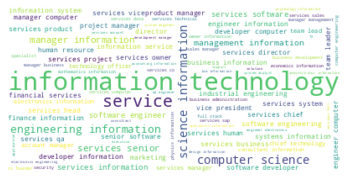

Cluster: 2


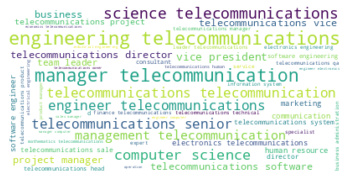

Cluster: 3


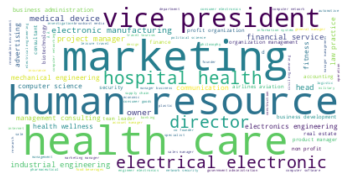

Cluster: 4


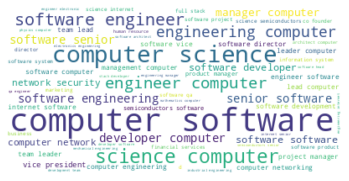

Cluster: 5


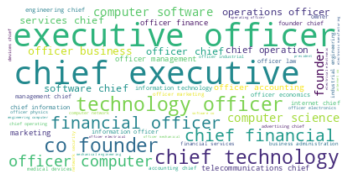

Cluster: 6


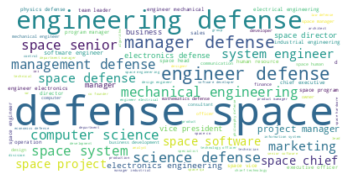

In [19]:
for k in range(0,true_k):
    s=df[df.cluster==k]
    text=s['text'].str.cat(sep=' ')
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

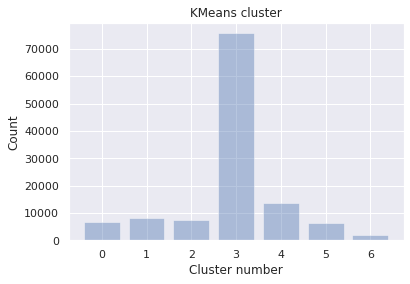

In [20]:
# how the data distributed across 7 clusters 

plt.bar([x for x in range(true_k)], df.groupby(['cluster'])['text'].count(), alpha = 0.4)
plt.title('KMeans cluster')
plt.xlabel("Cluster number")
plt.ylabel("Count")
plt.show()


In [21]:
def ten_most_popular_in_claster(cloum_name):
    for i in range(true_k):
        print(f"{'-'*8} cluster {i} {'-'*8}")
        s=df[df.cluster==i]
        for c,m in list(zip(
                s[cloum_name].value_counts().tolist()[:10]
               ,s[cloum_name].value_counts().index.tolist()[:10]
            )):
            print("major: {0: <30} count:{1}"''.format(m,c))

In [22]:
print(f"indusrty\n{len('industry')*'#'}")
ten_most_popular_in_claster("industry")

indusrty
########
-------- cluster 0 --------
major: higher education               count:6154
major: education management           count:359
major: primary/secondary education    count:58
major: internet                       count:12
major: government administration      count:8
major: design                         count:5
major: non-profit organization management count:5
major: electrical/electronic manufacturing count:4
major: human resources                count:3
major: transportation/trucking/railroad count:2
-------- cluster 1 --------
major: information technology and services count:7848
major: financial services             count:151
major: information services           count:133
major: semiconductors                 count:12
major: computer software              count:11
major: telecommunications             count:9
major: internet                       count:6
major: airlines/aviation              count:5
major: pharmaceuticals                count:5
major: environmental

In [23]:
print(f"job_title\n{len('job_title')*'#'}")
ten_most_popular_in_claster("job_title")

job_title
#########
-------- cluster 0 --------
major: professor                      count:344
major: lecturer                       count:283
major: senior lecturer                count:133
major: associate professor            count:97
major: researcher                     count:77
major: teacher                        count:71
major: assistant professor            count:65
major: dr                             count:60
major: teaching assistant             count:57
major: owner                          count:51
-------- cluster 1 --------
major: software engineer              count:183
major: project manager                count:147
major: senior software engineer       count:119
major: owner                          count:105
major: software developer             count:74
major: manager                        count:57
major: chief technology officer       count:55
major: account manager                count:54
major: product manager                count:53
major: programmer       

In [24]:
print(f"majors\n{len('majors')*'#'}")
ten_most_popular_in_claster("majors")

majors
######
-------- cluster 0 --------
major: philosophy                     count:452
major: education                      count:184
major: computer science               count:158
major: engineering                    count:150
major: chemistry                      count:149
major: biology                        count:136
major: physics                        count:130
major: psychology                     count:91
major: law                            count:87
major: management                     count:77
-------- cluster 1 --------
major: computer science               count:991
major: management                     count:361
major: engineering                    count:288
major: information systems            count:233
major: software engineering           count:186
major: business                       count:174
major: industrial engineering         count:140
major: finance                        count:122
major: electronics                    count:112
major: economics     

Cluster: 0


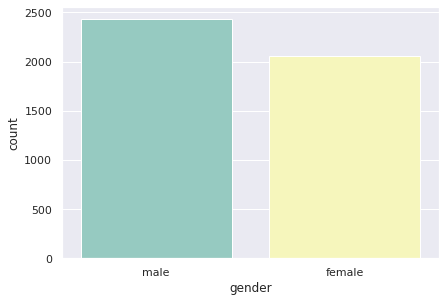

Cluster: 1


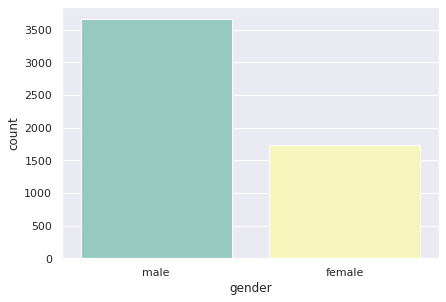

Cluster: 2


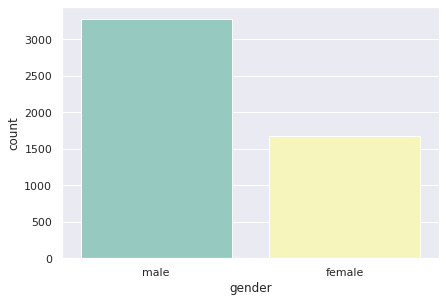

Cluster: 3


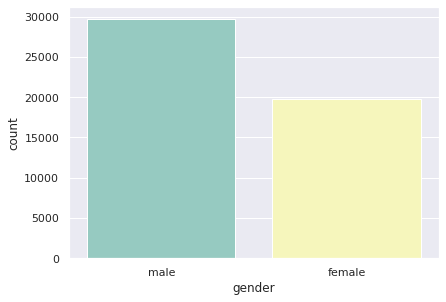

Cluster: 4


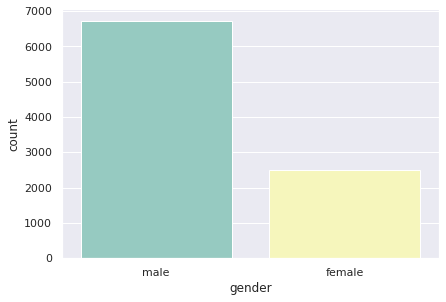

Cluster: 5


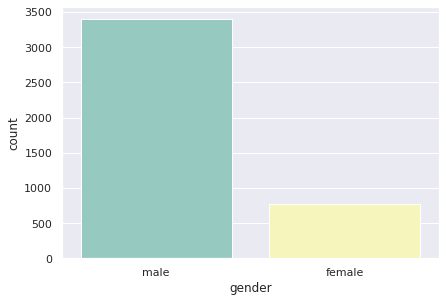

Cluster: 6


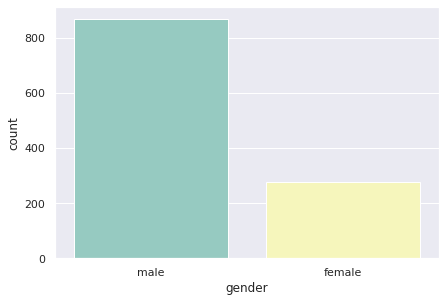

In [25]:
# gender per claster
sdf = df.dropna(subset=['gender','cluster'])
for k in range(true_k):
    print('Cluster: {}'.format(k))
    s=df[df.cluster==k]
    sns.countplot(data=s, x="gender",order=["male", "female"],palette="Set3")
    plt.tight_layout(pad = 0)
    plt.show()